# Batch inference

The API can perform batch inference.

For example, for large images, it can be useful to process them in patches.



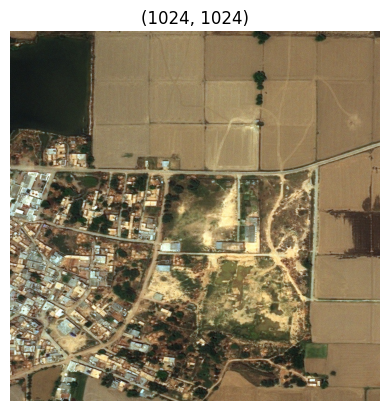

In [1]:

from PIL import Image
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from skimage.io import imsave

img_path = 'samples/deep_globe.jpg' # RGB
# img_path = 'samples/deep_globe.png' # RGBA
# img_path = 'samples/sentinel-2-l2a_2024-08-24.tif' 
# img_path = "samples/T31TDF_20240824T104021_RGB_10m.jp2 (1).tiff"

def tif2rgb(tif_path):
	# x = rio.open(tif_path).read((4,3,2)) # read RGB bands
	x = rio.open(tif_path).read((1,2,3)) # read RGB bands
	x = np.clip(x / 4000, 0, 1) # normalize to 0-1 with increased brightness
	x = (x * 255).astype(np.uint8) # convert to uint8
	x = x.transpose(1,2,0) # convert to HWC
	# x = resize(x, (256,256))
	# x = (x * 255).astype(np.uint8) # convert to uint8
	# crop
	# x = x[-512:,-512:,:]
	print(x.shape)
	new_path = tif_path.replace('.tif', '.png')
	imsave(new_path, x)
	return new_path

# img_path = tif2rgb(img_path)

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(img.size)
plt.show()

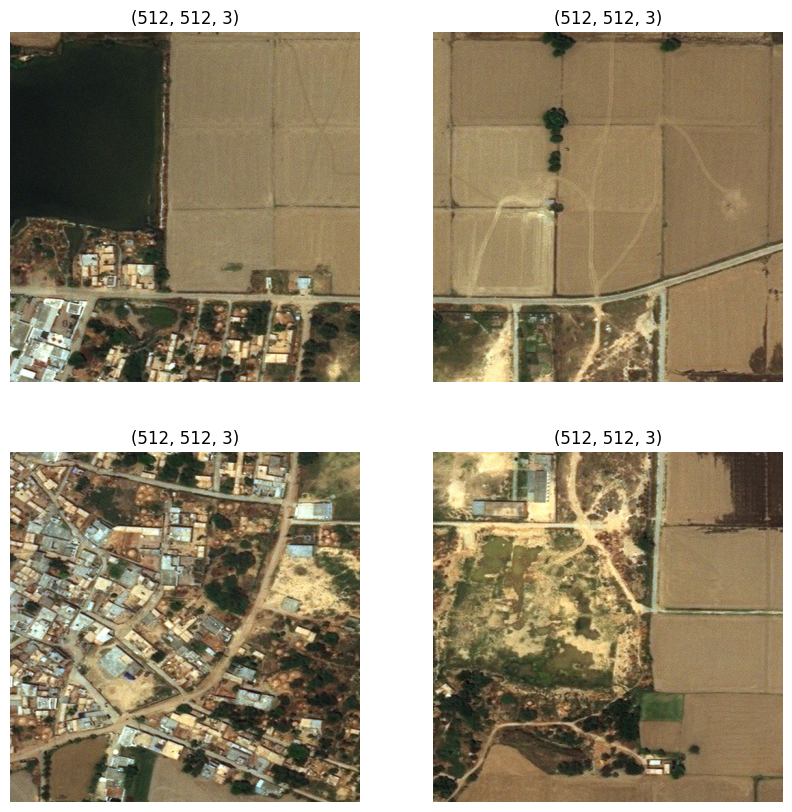

In [2]:
# split the image into 4x4 non-overlapping patches
N = 2
img_array = np.array(img)
patches_h = np.array_split(img_array, N, axis=0)  # split horizontally first
patches = []
for patch in patches_h:
    patches.extend(np.array_split(patch, N, axis=1))  # split each half vertically

# plot
fig = plt.figure(figsize=(10,10))
for i, patch in enumerate(patches):
    ax = fig.add_subplot(N,N,i+1)
    ax.imshow(patch)
    ax.axis('off')
    ax.set_title(patch.shape)
plt.show()


In [3]:
import requests
from IPython.display import JSON
import json

url = f'http://localhost:8000/RoadSegmentationQ2'
# url  = f'https://eotdl.dev.gda.adamplatform.eu/RoadSegmentationQ2'

headers = {	
    "X-API-Key": "123"
}

res = requests.get(url, headers=headers)

res.json()

{'detail': "Cannot locate timezone 'UTC': discover_tz_dir failed to find zoneinfo\n"}

Fetch the masks for each patch concurrently (API can process in batch mode)

In [4]:
import asyncio
import aiohttp
from PIL import Image
import io

async def send_request(session, patch):
    # Convert patch to PIL Image and save to bytes buffer
    patch_img = Image.fromarray(patch.astype('uint8'))
    img_byte_arr = io.BytesIO()
    patch_img.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)
    
    data = aiohttp.FormData()
    data.add_field('image', img_byte_arr, filename='patch.png')
    
    async with session.post(url, data=data, headers=headers) as response:
        content = await response.read()
        image_bytes = io.BytesIO(content)
        img = Image.open(image_bytes)
        return np.array(img)

async def process_patches():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for patch in patches:  # patches was created earlier by splitting the image
            tasks.append(send_request(session, patch))
        
        results = await asyncio.gather(*tasks)
        return results

# For Jupyter notebook, use this instead of asyncio.run():
patch_results = await process_patches()


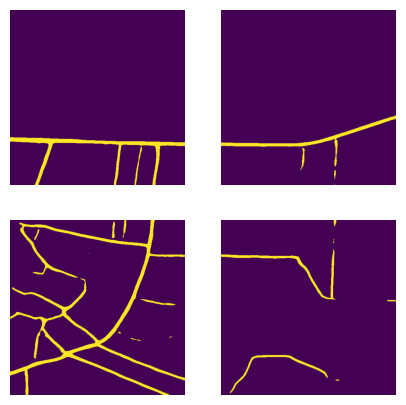

In [5]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Process and display results 
fig, axes = plt.subplots(N, N, figsize=(5, 5))
for i, logits in enumerate(patch_results):
    row = i // N
    col = i % N
    probas = sigmoid(logits)
    mask = probas > 0.5
    axes[row, col].imshow(mask)
    axes[row, col].axis('off')
plt.show()

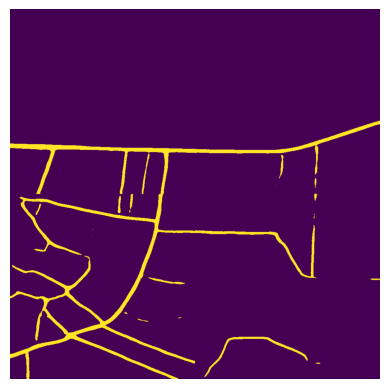

In [6]:
# reconstruct the image

output_img = np.zeros(img_array.shape[:2], dtype=np.uint8)
for i, patch in enumerate(patches):
    row = i // N
    col = i % N
    probas = sigmoid(patch_results[i])
    mask = probas > 0.5
    output_img[row*512:(row+1)*512, col*512:(col+1)*512] = mask

plt.imshow(output_img)
plt.axis('off')
plt.show()

We could add this feature in the API, but this would mean very large requests... better to take care of it in the client.

Can improve resutls with overlapping windows and averaging for overlapping areas between patches.

It can be used to perform inference on different images in parallel as well (not only windowed images).